# 분류 - 캐글 산탄데르 고객 만족 예측

캐글의 산탄데르 고객 만족(Santander Customer Satisfaction) 데이터셋을 기반으로 고객 만족 여부를 XGBoost와 LightGBM을 활용해 예측한다.

기본 설정에서 시작하여 점진적인 하이퍼 파라미터 튜닝을 통해 XGBoost, LightGBM 모델의 성능을 개선하고, 최종적으로 ROC AUC 성능이 가장 높은 하이퍼 파라미터 조합을 도출하는 것을 목표로 한다.

- 산탄데르 고객 만족 예측 분석은 370개 피처로 주어진 데이터 세트 기반에서 고객 만족 여부를 예측한다. 피처 이름은 모두 익명 처리되어 피처 이름만을는 어떤 속싱인지 추정할 수 없다.

- 클래스 레이블 명은 TARGET이며 이 값이 1이면 불만을 가진 고객, 0이면 만족한 고객이다.

- 모델의 성능 평가는 ROC-AUC로 평가한다. 대부분이 만족이고 불만족인 데이터는 일부일 것이기 때문에 정확도 수치보다는 ROC-AUC가 더 적합하다.

<br>

## 데이터 전처리

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

cust_df = pd.read_csv('/content/drive/MyDrive/DS/train_santander.csv')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [3]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [4]:
# 불만족 고객 비율 계산
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()    # cf. len(cust_df): 전체 행 수 반환(결측값 포함)
print(f'unsatisfied 비율은 {unsatisfied_cnt / total_cnt:.2f}')

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


In [5]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [6]:
cust_df['var3'].value_counts()

,count
var3,
2,74165
8,138
-999999,116
9,110
3,108
...,...
63,1
194,1
40,1


- var3의 min 값이 -999999인데, NaN이나 특정 예외 값을 -999999로 변환했을 것이다.

<br>

- var3는 int 타입이고 다른 값에 비해 편차가 심하므로 최빈값인 2로 변환
- ID 피처는 단순 식별자에 불과하므로 drop
- 데이터를 피처 세트와 레이블 세트로 분리

In [7]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트 분리
# 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print(f'피처 데이터 shape: {X_features.shape}')

피처 데이터 shape: (76020, 369)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print(f'학습 세트 Shape: {X_train.shape}, 테스트 세트 Shape: {X_test.shape}')

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts() / train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts() / test_cnt)

학습 세트 Shape: (60816, 369), 테스트 세트 Shape: (15204, 369)
 학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


- 학습과 테스트 데이터 세트 모두 TARGET 값의 분포가 원본 데이터와 유사하게 전체 데이터의 4% 정도의 불만족 값(1)으로 만들어졌다.

- XGBoost의 조기 중단(early stopping)의 검증 데이터 세트로 사용하기 위해서 X_train, y_train을 다시 쪼개서 학습과 검증 데이터 세트로 만들겠다.

In [9]:
# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train,
                                            y_train,
                                            test_size=0.3,
                                            random_state=0)

<br>

## XGBoost 모델 학습과 하이퍼 하라미터 튜닝

XGBoost 모델의 성능을 극대화하기 위한 하이퍼파라미터 최적화 작업

- Hyperopt 라이브러리를 활용하여 최적 조합을 자동으로 찾아낸다.
- 평가 기준은 ROC-AUC이고, 목표는 AUC가 가장 높은 파라미터 조합을 찾는 것이다.

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# 모델 정의
xgb_clf = XGBClassifier(
    tree_method='gpu_hist',      # GPU 사용 설정
    predictor='gpu_predictor',   # 예측 시에도 GPU 사용
    gpu_id=0,                    # 사용할 GPU 번호
    n_estimators=500,            # 최대 트리 개수
    learning_rate=0.05,          # 학습률
    early_stopping_rounds=100,   # 조기 종료 조건
    eval_metric='auc',           # 평가 지표
    use_label_encoder=False,     # 경고 방지
    random_state=156,
    # n_jobs=-1                    # 멀티코어 사용
)

# 모델 학습
#  - XGBoost가 eval_set에 지정된 가장 마지막 데이터셋을 기준으로 평가하며
#  - 이 데이터에서 eval_metric 기준으로 성능이 개선되지 않으면 학습을 멈춤
xgb_clf.fit(
    X_tr, y_tr,
    # eval_set=[(X_tr, y_tr), (X_val, y_val)],
    eval_set=[(X_val, y_val)],   # 조기 종료 조건: 검증 데이터셋(_val)
    verbose=False                # 학습 로그 출력 여부 (필요 시 True)
)

# ROC-AUC 평가
xgb_roc_score = roc_auc_score(
    y_test, xgb_clf.predict_proba(X_test)[:, 1]  # 클래스 1에 대한 확률
)

print(f'ROC AUC: {xgb_roc_score:.4f}')

ROC AUC: 0.8413


- 테스트 데이터 세트로 예측 시 ROC AUC는 약 0.8413

- 이제 HyperOpt를 이용한 베이지안 최적화 기법으로 XGBoost의 하이퍼 파라미터 튜닝을 수행해 본다.

### 탐색 범위 정의

탐색할 하이퍼 파라미터 범위(search space)를 정의한다.

- `hp.quniform`: 정수 범위를 탐색할 때 사용 (`start`, `end`, `step`)
- `hp.uniform`: 연속적인 실수 범위에서 랜덤 선택

In [14]:
from hyperopt import hp

# max_depth는 5에서 15까지 1간격으로, min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
}

### 목적 함수 정의

전달된 search_space 파라미터 조합을 사용해 XGBClassifier 모델을 정의하고,  
3-Fold 교차검증을 통해 이 조합의 평균 ROC-AUC를 평가한다.

- 목적함수는 3 Fold 교차 검증을 이용해 평균 ROC-AUC 값을 반환하되 -1을 곱해주어 최대 ROC-AUC 값이 최소 반환값이 되게 한다.
    - Hyperopt는 목적 함수의 값을 최소화하기 때문에, AUC가 높을수록 좋은 조합이므로 음수로 반환

- 교차 검증 시 XGBoost의 조기 중단과 검증 데이터 성능 평가를 위해서 KFold 클래스를 이용하여 직접 학습과 검증 데이터 세트를 추출하고 이를 교차 검증 횟수만큼 학습과 성능 평가를 수행한다.

- 수행 시간을 줄이기 위해 estimators는 100으로, early_stopping_rounds도 30으로 줄여서 테스트한 뒤 나중에 하이퍼 파라미터 튜닝이 완료되면 다시 증가시킨다.

In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# 목적 함수 설정
# 추후 fmin()에서 호출 시 search_space 값으로 XGBClassifier 교차 검증 학습 후 '-1 * roc_auc' 평균 값을 반환
def objective_func(search_space):
    xgb_clf = XGBClassifier(
                            tree_method='gpu_hist',     # GPU 사용 설정
                            predictor='gpu_predictor',  # 예측 시에도 GPU 사용
                            gpu_id=0,                   # 사용할 GPU 번호
                            n_estimators=100,
                            max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate'],
                            early_stopping_rounds=30,
                            eval_metric='auc',
                            use_label_encoder=False,
                            # n_jobs=-1  # 멀티코어 사용
                           )

    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list= []

    # 3개 k-fold방식 적용
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        # 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
        xgb_clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    verbose=50
                    )

        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)

    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되,
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환
    return -1 * np.mean(roc_auc_list)

### 최적의 파라미터 도출

fmin() 함수를 호출해 max_eval=50회만큼 반복하면서 최적의 하이퍼 파라미터를 도출해 본다.

- `fn`: 최적화할 목적 함수
- `space`: 탐색 범위
- `algo`: 사용할 탐색 알고리즘 (`tpe.suggest`는 확률적 베이지안 최적화)
- `max_evals=50`: 최대 50번 반복해서 최적 조합 탐색
- `trials`: 탐색 과정을 저장할 객체

In [25]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수 호출
# max_evals에 지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50,  # 최대 반복 횟수 지정
            trials=trials,
            rstate=np.random.default_rng(seed=30))

print('best:', best)  # ROC AUC 기준 가장 성능이 좋았던 하이퍼 파라미터 조합 출력

Streaming output truncated to the last 5000 lines.
[82]	validation_0-auc:0.90666	validation_1-auc:0.83749
[83]	validation_0-auc:0.90675	validation_1-auc:0.83755
[84]	validation_0-auc:0.90697	validation_1-auc:0.83765
[85]	validation_0-auc:0.90708	validation_1-auc:0.83758
[86]	validation_0-auc:0.90742	validation_1-auc:0.83745
[87]	validation_0-auc:0.90746	validation_1-auc:0.83737
[88]	validation_0-auc:0.90750	validation_1-auc:0.83731
[89]	validation_0-auc:0.90759	validation_1-auc:0.83733
[90]	validation_0-auc:0.90840	validation_1-auc:0.83711
[91]	validation_0-auc:0.90867	validation_1-auc:0.83709
[92]	validation_0-auc:0.90870	validation_1-auc:0.83713
[93]	validation_0-auc:0.90902	validation_1-auc:0.83724
[94]	validation_0-auc:0.90953	validation_1-auc:0.83712
[95]	validation_0-auc:0.90987	validation_1-auc:0.83703
[96]	validation_0-auc:0.90995	validation_1-auc:0.83693
[0]	validation_0-auc:0.83355	validation_1-auc:0.80677
[1]	validation_0-auc:0.82358	validation_1-auc:0.79474
[2]	validation_0

- 도출된 최적 하이퍼 파라미터를 기반으로 XGBClassifier를 재학습시키고 테스트 데이터 세트에서 ROC AUC를 측정한다.

In [26]:
# n_estimators를 500으로 증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행
xgb_clf = XGBClassifier(n_estimators=500,
                        max_depth=int(best['max_depth']),
                        min_child_weight=int(best['min_child_weight']),
                        colsample_bytree=round(best['colsample_bytree'], 5),
                        learning_rate=round(best['learning_rate'], 5),
                        early_stopping_rounds=100,
                        eval_metric='auc',
                        use_label_encoder=False
                       )

# 학습 수행
xgb_clf.fit(X_tr, y_tr,
            eval_set=[(X_tr, y_tr), (X_val, y_val)],
            verbose=False)

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print(f'ROC AUC: {xgb_roc_score:.4f}')

ROC AUC: 0.8465


- ROC-AUC가 이전의 0.8413에서 하이퍼 파라미터 튜닝 이후 0.8465로 개선되었다.

>XGBoost가 GBM을 기반으로 하고 있기 때문에 수행 시간이 상당히 요구된다. 앙상블 계열 알고리즘에서 하이퍼 파라미터 튜닝으로 성능 수치 개선이 급격하게 되는 경우는 많지 않다. 앙상블 계열 알고리즘은 과적합이나 잡음에 기본적으로 뛰어난 알고리즘이기 때문이다.

기존 HyperOpt 기반 튜닝 결과를 기반으로, 추가 실험을 통해 ROC AUC 기준 성능을 최대한 향상시키는 하이퍼파라미터 조합을 도출한다.

In [42]:
# 최적의 하이퍼 파라미터 찾기
xgb_clf = XGBClassifier(n_estimators=500,
                        max_depth=6,
                        min_child_weight=5,
                        colsample_bytree=0.65,
                        learning_rate=0.06,
                        early_stopping_rounds=100,
                        eval_metric='auc',
                        use_label_encoder=False
                       )

# 학습 수행
xgb_clf.fit(X_tr, y_tr,
            eval_set=[(X_tr, y_tr), (X_val, y_val)],
            verbose=False)

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print(f'ROC AUC: {xgb_roc_score:.4f}')

ROC AUC: 0.8471


<br>

- 튜닝된 모델에서 각 피처의 중요도를 피처 중요도 그래프로 나타내 본다.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

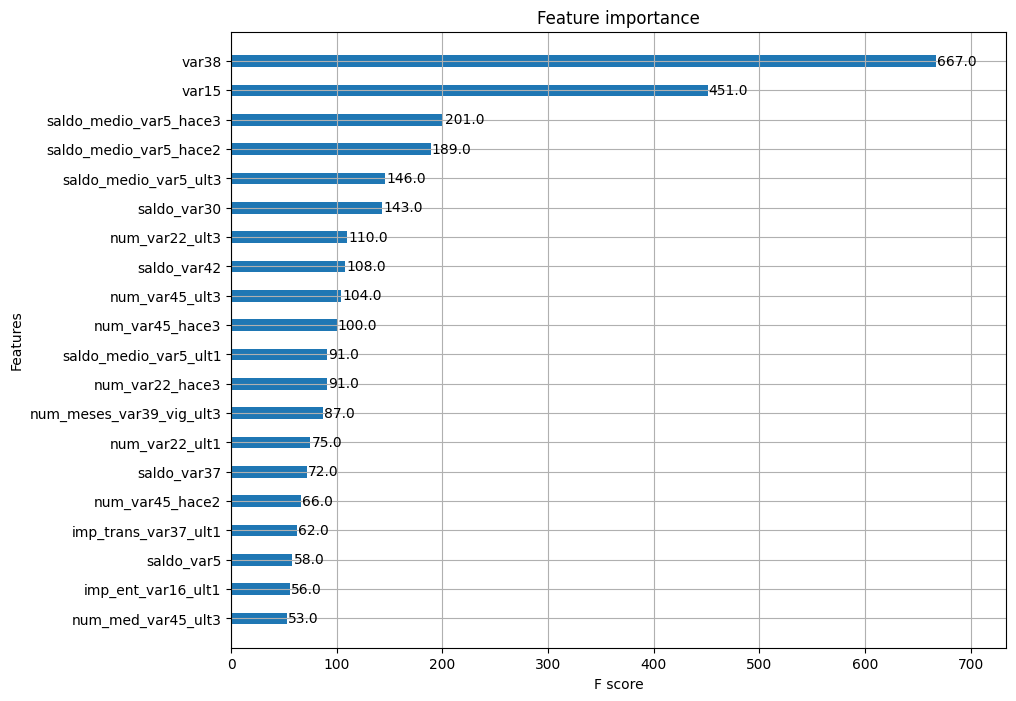

In [27]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)

- XGBoost의 예측 성능을 좌우하는 가장 중요한 피처는 var38, var15 순임을 알 수 있다.


<br>

## LightGBM 모델 학습과 하이퍼 파라미터 튜닝

LightGBM을 이용해 모델을 학습하고 하이퍼 파라미터 튜닝해 에측 성능을 평가한다.

- 앞의 XGBoost 코드에서 만들어진 데이터 세트를 기반으로 LightGB으로 학습을 수행하고 ROC-AUC를 측정한다.

In [10]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.metrics import roc_auc_score

lgbm_clf = LGBMClassifier(n_estimators=500,
                          force_row_wise=True,  # 멀티스레딩 경고 로그 제거
                          verbosity=-1  # 내부 C++ 로그 제거: [LightGBM] [Info] ...
                          )

# 학습
lgbm_clf.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    # 조기 종료 로그, 평가 지표 로그 제거
    callbacks=[early_stopping(stopping_rounds=100, verbose=False), log_evaluation(period=0)]
)

# 평가
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1])
print(f'ROC AUC: {lgbm_roc_score:.4f}')

ROC AUC: 0.8384


- LightGBM 수행 결과 ROC AUC가 약 0.8384를 나타낸다.
- HyperOpt를 이용하여 다양한 하이퍼 파라미터에 대한 튜닝을 수행해 보겠다.

### 탐색 범위 정의

In [12]:
from hyperopt import hp

lgbm_search_space = {'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth': hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples': hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample': hp.uniform('subsample', 0.7, 1),
                     'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
                    }

### 목적 함수 정의

In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

def objective_func(search_space):
    lgbm_clf =  LGBMClassifier(n_estimators=100,
                               num_leaves=int(search_space['num_leaves']),
                               max_depth=int(search_space['max_depth']),
                               min_child_samples=int(search_space['min_child_samples']),
                               subsample=search_space['subsample'],
                               learning_rate=search_space['learning_rate'],
                               force_row_wise=True,  # 멀티스레딩 경고 로그 제거
                               verbosity=-1  # 내부 C++ 로그 제거: [LightGBM] [Info] ...
                               )
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []

    # 3개 k-fold방식 적용
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

        # 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
        lgbm_clf.fit(X_tr, y_tr,
                     eval_set=[(X_tr, y_tr), (X_val, y_val)],
                     eval_metric='auc',
                     # 조기 종료 로그, 평가 지표 로그 제거
                     callbacks=[early_stopping(stopping_rounds=100, verbose=False), log_evaluation(period=0)]
                     )

        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)

    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되,
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환
    return -1 * np.mean(roc_auc_list)

### 최적의 파라미터 도출

In [17]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin() 함수 호출
# max_evals에 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
best = fmin(fn=objective_func,
            space=lgbm_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수 지정
            trials=trials,
            rstate=np.random.default_rng(seed=30))

print('best:', best)

100%|██████████| 50/50 [09:10<00:00, 11.00s/trial, best loss: -0.8363519441070282]
best: {'learning_rate': np.float64(0.059417910202459526), 'max_depth': np.float64(115.0), 'min_child_samples': np.float64(64.0), 'num_leaves': np.float64(38.0), 'subsample': np.float64(0.8226278759396897)}


- 이들 하이퍼 파라미터를 이용하여 LightGBM을 학습 후에 테스트 데이터 세트에서 ROC-AUC를 평가해 본다.

In [19]:
lgbm_clf =  LGBMClassifier(n_estimators=500,
                           num_leaves=int(best['num_leaves']),
                           max_depth=int(best['max_depth']),
                           min_child_samples=int(best['min_child_samples']),
                           subsample=round(best['subsample'], 5),
                           learning_rate=round(best['learning_rate'], 5),
                           force_row_wise=True,  # 멀티스레딩 경고 로그 제거
                           verbosity=-1  # 내부 C++ 로그 제거: [LightGBM] [Info] ...
                          )

lgbm_clf.fit(X_tr, y_tr,
             eval_set=[(X_tr, y_tr), (X_val, y_val)],
             eval_metric='auc',
             # 조기 종료 로그, 평가 지표 로그 제거
             callbacks=[early_stopping(stopping_rounds=100, verbose=False), log_evaluation(period=0)]
             )

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print(f'ROC AUC: {lgbm_roc_score:.4f}')

ROC AUC: 0.8423


- LightGBM의 경우 테스트 데이터 세트에서 ROC-AUC가 이전의 0.8384에서 하이퍼 파라미터 튜닝 이후 0.8423로 개선되었다.

기존 HyperOpt 기반 튜닝 결과를 기반으로, 추가 실험을 통해 ROC AUC 기준 성능을 최대한 향상시키는 하이퍼파라미터 조합을 도출한다.

In [60]:
# 최적의 하이퍼 파라미터 찾기
lgbm_clf =  LGBMClassifier(n_estimators=500,
                           num_leaves=37,
                           max_depth=10,
                           min_child_samples=64,
                           subsample=0.82,
                           learning_rate=0.0594,
                           force_row_wise=True,
                           verbosity=-1
                          )

lgbm_clf.fit(X_tr, y_tr,
             eval_set=[(X_tr, y_tr), (X_val, y_val)],
             eval_metric='auc',
             # 조기 종료 로그, 평가 지표 로그 제거
             callbacks=[early_stopping(stopping_rounds=100, verbose=False), log_evaluation(period=0)]
             )

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print(f'ROC AUC: {lgbm_roc_score:.4f}')

ROC AUC: 0.8443
